<a href="https://colab.research.google.com/github/ArtyomHov/tensorflow-zero-to-mastery/blob/master/06_transfer_learning_in_tensorflow_part_3_scaling_up_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensorflow Part 3: Scaling up (Food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food)
Our goal is to beat original Food101 paper with 10 percent of training data (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy accross 101 classes.

In [2]:
# Check if we're using GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In previous notebooks we've created a series of helper functions to do different tasks, let's download them.

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2024-10-23 15:53:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-23 15:53:06 (95.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image-data-modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-10-23 15:53:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 142.251.183.207, 209.85.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   288MB/s    in 5.6s    

2024-10-23 15:53:19 (279 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_class

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into model
* Build a headless (no top layers) Functional EfficientNetV2B0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Rescaling


# Setup data augmentation
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
  RandomZoom(0.2),
  # Rescaling(1/255.) # rescale inputs to between 0 and 1
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


24274472/24274472 [==============================] - 0s 0us/step


In [10]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                         epochs=5,
                                        #  steps_per_epoch=len(train_data_all_10_percent),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 83s 318ms/step - loss: 3.5262 - accuracy: 0.2400 - val_loss: 2.6627 - val_accuracy: 0.4113
Epoch 2/5
237/237 [==============================] - 70s 298ms/step - loss: 2.4326 - accuracy: 0.4466 - val_loss: 2.2221 - val_accuracy: 0.4756
Epoch 3/5
237/237 [==============================] - 70s 296ms/step - loss: 2.0520 - accuracy: 0.5129 - val_loss: 1.9726 - val_accuracy: 0.5183
Epoch 4/5
237/237 [==============================] - 71s 298ms/step - loss: 1.8405 - accuracy: 0.5521 - val_loss: 1.8776 - val_accuracy: 0.5339
Epoch 5/5
237/237 [==============================] - 69s 290ms/step - loss: 1.6938 - accuracy: 0.5839 - val_loss: 1.8131 - val_accuracy: 0.5471


In [12]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 134s 169ms/step - loss: 1.6088 - accuracy: 0.5791


[1.6088131666183472, 0.5790891051292419]

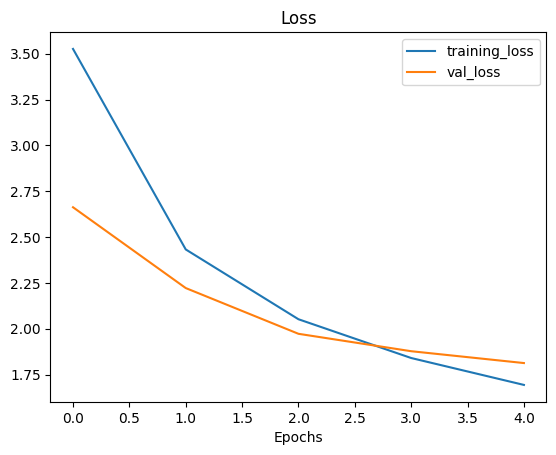

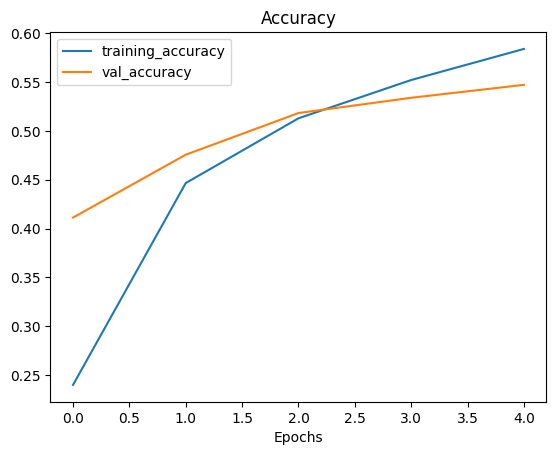

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning rate (it's typicaly best practice to lower learning rate for fine-tuning.)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling_layer True
output_layer True


In [17]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 #model has already done 5 epoch feature extraction, this is the total number of epochs we're after

# Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 78s 301ms/step - loss: 1.4813 - accuracy: 0.6283 - val_loss: 1.7646 - val_accuracy: 0.5347
Epoch 6/10
237/237 [==============================] - 69s 290ms/step - loss: 1.3880 - accuracy: 0.6408 - val_loss: 1.7644 - val_accuracy: 0.5358
Epoch 7/10
237/237 [==============================] - 69s 292ms/step - loss: 1.3209 - accuracy: 0.6533 - val_loss: 1.7946 - val_accuracy: 0.5323
Epoch 8/10
237/237 [==============================] - 69s 291ms/step - loss: 1.2723 - accuracy: 0.6594 - val_loss: 1.7624 - val_accuracy: 0.5365
Epoch 9/10
237/237 [==============================] - 68s 285ms/step - loss: 1.2392 - accuracy: 0.6713 - val_loss: 1.7398 - val_accuracy: 0.5474
Epoch 10/10
237/237 [==============================] - 68s 286ms/step - loss: 1.2083 - accuracy: 0.6803 - val_loss: 1.7603 - val_accuracy: 0.5400


In [19]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 134s 170ms/step - loss: 1.4797 - accuracy: 0.6017


[1.4796923398971558, 0.6017029881477356]

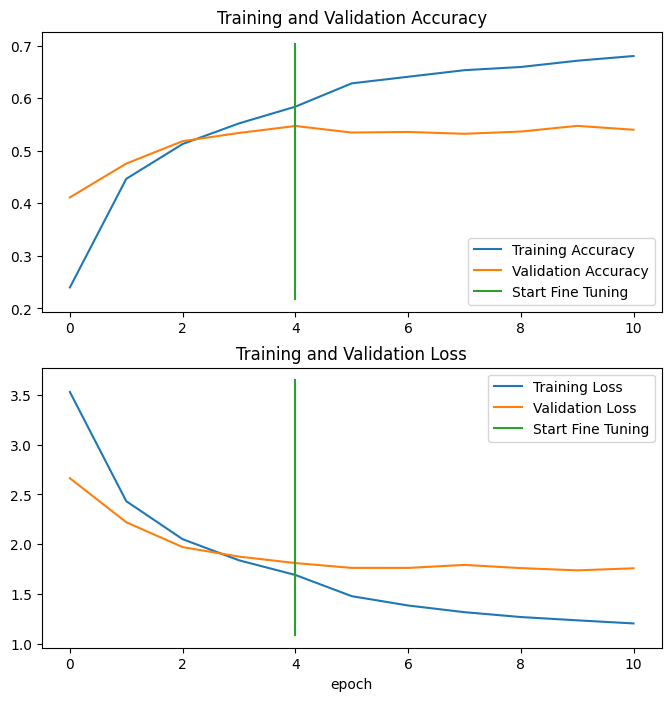

In [20]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [21]:
# Save our fine-tuning model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [22]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_data_model.keras")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 136s 169ms/step - loss: 1.4797 - accuracy: 0.6017


[1.4796923398971558, 0.6017029881477356]

In [24]:
# The results from our loaded model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4796923398971558, 0.6017029881477356]

## Making predictions with our trained model

In [25]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 136s 170ms/step


In [26]:
len(test_data)

790

In [27]:
# How many predictions are there
len(pred_probs)

25250

In [28]:
# What's the shape of our predictions
pred_probs.shape

(25250, 101)

In [29]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[1.04135240e-03, 2.25401200e-05, 1.34312078e-01, ...,
        8.74764964e-07, 7.34905479e-04, 3.97574004e-05],
       [6.73150182e-01, 9.31372739e-08, 2.64006704e-02, ...,
        1.20775471e-03, 3.15364196e-06, 5.23114650e-05],
       [4.91397023e-01, 3.02501081e-04, 3.47765945e-02, ...,
        2.69541983e-03, 1.01471716e-03, 7.62028154e-04],
       ...,
       [1.83704659e-01, 2.68144754e-06, 3.53904366e-02, ...,
        1.16875127e-03, 5.76188497e-04, 4.49781888e-04],
       [7.60988966e-02, 3.75598975e-05, 1.45511866e-01, ...,
        1.24664046e-03, 3.75980104e-04, 7.32359127e-04],
       [3.12494993e-01, 4.81985523e-07, 1.33607695e-02, ...,
        4.84307809e-03, 2.46763884e-05, 4.36676288e-04]], dtype=float32)

In [30]:
# What does the first prediction probability array looks like
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([1.04135240e-03, 2.25401200e-05, 1.34312078e-01, 4.94425592e-07,
        4.43629069e-05, 7.73567808e-05, 1.58845196e-05, 2.30035948e-06,
        1.53525601e-04, 2.29454934e-04, 4.65568110e-06, 4.13199450e-05,
        6.27203335e-05, 5.88945932e-06, 4.98723518e-03, 8.66503268e-03,
        6.35448669e-04, 2.21638402e-04, 1.53274275e-03, 2.48370023e-04,
        1.16250501e-03, 3.39919575e-06, 1.70530475e-05, 9.41121289e-06,
        8.78910068e-05, 4.57670132e-04, 1.53985736e-03, 3.29265663e-06,
        1.98949268e-03, 3.98543161e-05, 2.31306149e-06, 1.46928054e-04,
        4.04658541e-03, 5.33448547e-05, 3.94508848e-03, 3.97175681e-05,
        9.14902193e-04, 8.24252202e-04, 1.66038536e-02, 9.98440592e-05,
        6.30447117e-04, 3.89679219e-04, 2.48447614e-05, 1.08372260e-04,
        5.73998514e-05, 7.63426142e-05, 1.27336811e-04, 1.05701714e-04,
        3.13931560e-05, 2.61404794e-02, 5.34434628e-04, 1.84551463e-04,
        6.98481351e-02, 1.38119292e-02, 1.36590563e-06, 5.346482

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [31]:
# We get one prediction probability per class (in our case there's 101 predictions probabilities)
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.04135240e-03 2.25401200e-05 1.34312078e-01 4.94425592e-07
 4.43629069e-05 7.73567808e-05 1.58845196e-05 2.30035948e-06
 1.53525601e-04 2.29454934e-04 4.65568110e-06 4.13199450e-05
 6.27203335e-05 5.88945932e-06 4.98723518e-03 8.66503268e-03
 6.35448669e-04 2.21638402e-04 1.53274275e-03 2.48370023e-04
 1.16250501e-03 3.39919575e-06 1.70530475e-05 9.41121289e-06
 8.78910068e-05 4.57670132e-04 1.53985736e-03 3.29265663e-06
 1.98949268e-03 3.98543161e-05 2.31306149e-06 1.46928054e-04
 4.04658541e-03 5.33448547e-05 3.94508848e-03 3.97175681e-05
 9.14902193e-04 8.24252202e-04 1.66038536e-02 9.98440592e-05
 6.30447117e-04 3.89679219e-04 2.48447614e-05 1.08372260e-04
 5.73998514e-05 7.63426142e-05 1.27336811e-04 1.05701714e-04
 3.13931560e-05 2.61404794e-02 5.34434628e-04 1.84551463e-04
 6.98481351e-02 1.38119292e-02 1.36590563e-06 5.34648250e-04
 3.02649802e-04 2.90782191e-04 7.00120348e-

In [32]:
# GET THE PRED CLASSES OF EACH CLASS
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([85,  0,  0,  0,  8, 78, 29, 46,  9, 41])

In [33]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array or all of our model predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [34]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where 1 appears
y_labels[:10] # Look at the first 10
#

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels is to find the accuracy score.

In [36]:
# Let's try scikit-learns accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6017029702970297

## Let's get visual: making a confusion matrix

In [37]:
from helper_functions import make_confusion_matrix

In [38]:
# Get list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [39]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# we need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [40]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification matrices per class (e.g. precision, recall and F1) called [classification report](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.40      0.14      0.21       250
           1       0.70      0.60      0.65       250
           2       0.64      0.48      0.55       250
           3       0.75      0.58      0.65       250
           4       0.48      0.46      0.47       250
           5       0.63      0.33      0.43       250
           6       0.75      0.78      0.77       250
           7       0.85      0.68      0.76       250
           8       0.30      0.51      0.38       250
           9       0.30      0.78      0.43       250
          10       0.57      0.45      0.50       250
          11       0.65      0.58      0.61       250
          12       0.70      0.62      0.66       250
          13       0.65      0.50      0.56       250
          14       0.46      0.64      0.54       250
          15       0.36      0.34      0.35       250
          16       0.63      0.55      0.58       250
          17       0.42    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.
How about we create a visualization to get a better understanding?

In [42]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                                                    y_pred=pred_classes,
                                                    output_dict=True)
classification_report_dict

{'0': {'precision': 0.3956043956043956,
  'recall': 0.144,
  'f1-score': 0.21114369501466276,
  'support': 250.0},
 '1': {'precision': 0.695852534562212,
  'recall': 0.604,
  'f1-score': 0.6466809421841542,
  'support': 250.0},
 '2': {'precision': 0.6436170212765957,
  'recall': 0.484,
  'f1-score': 0.5525114155251142,
  'support': 250.0},
 '3': {'precision': 0.7461139896373057,
  'recall': 0.576,
  'f1-score': 0.6501128668171557,
  'support': 250.0},
 '4': {'precision': 0.4831932773109244,
  'recall': 0.46,
  'f1-score': 0.4713114754098361,
  'support': 250.0},
 '5': {'precision': 0.6307692307692307,
  'recall': 0.328,
  'f1-score': 0.43157894736842106,
  'support': 250.0},
 '6': {'precision': 0.7509578544061303,
  'recall': 0.784,
  'f1-score': 0.7671232876712328,
  'support': 250.0},
 '7': {'precision': 0.8542713567839196,
  'recall': 0.68,
  'f1-score': 0.7572383073496659,
  'support': 250.0},
 '8': {'precision': 0.3047619047619048,
  'recall': 0.512,
  'f1-score': 0.38208955223880

Let's plot all of our classes F1-scores...

In [43]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.21114369501466276,
 'baby_back_ribs': 0.6466809421841542,
 'baklava': 0.5525114155251142,
 'beef_carpaccio': 0.6501128668171557,
 'beef_tartare': 0.4713114754098361,
 'beet_salad': 0.43157894736842106,
 'beignets': 0.7671232876712328,
 'bibimbap': 0.7572383073496659,
 'bread_pudding': 0.382089552238806,
 'breakfast_burrito': 0.43449048152295633,
 'bruschetta': 0.5044642857142857,
 'caesar_salad': 0.6127659574468085,
 'cannoli': 0.6595744680851063,
 'caprese_salad': 0.5610859728506787,
 'carrot_cake': 0.5360134003350083,
 'ceviche': 0.3492723492723493,
 'cheese_plate': 0.5842217484008528,
 'cheesecake': 0.43222003929273084,
 'chicken_curry': 0.5084033613445378,
 'chicken_quesadilla': 0.5528846153846154,
 'chicken_wings': 0.72552783109405,
 'chocolate_cake': 0.5821782178217821,
 'chocolate_mousse': 0.39065817409766457,
 'churros': 0.7368421052631579,
 'clam_chowder': 0.7403100775193798,
 'club_sandwich': 0.631578947368421,
 'crab_cakes': 0.38481675392670156,
 'creme_brule

In [44]:
# Turn f1-scores into dataframes for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-scores": list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)

In [45]:
f1_scores

class_names  f1-scores
33            edamame   0.958904
63           macarons   0.891775
75                pho   0.862903
65            mussels   0.835821
54  hot_and_sour_soup   0.835644
..                ...        ...
15            ceviche   0.349272
93              steak   0.297694
77          pork_chop   0.285036
39          foie_gras   0.276215
0           apple_pie   0.211144

[101 rows x 2 columns]

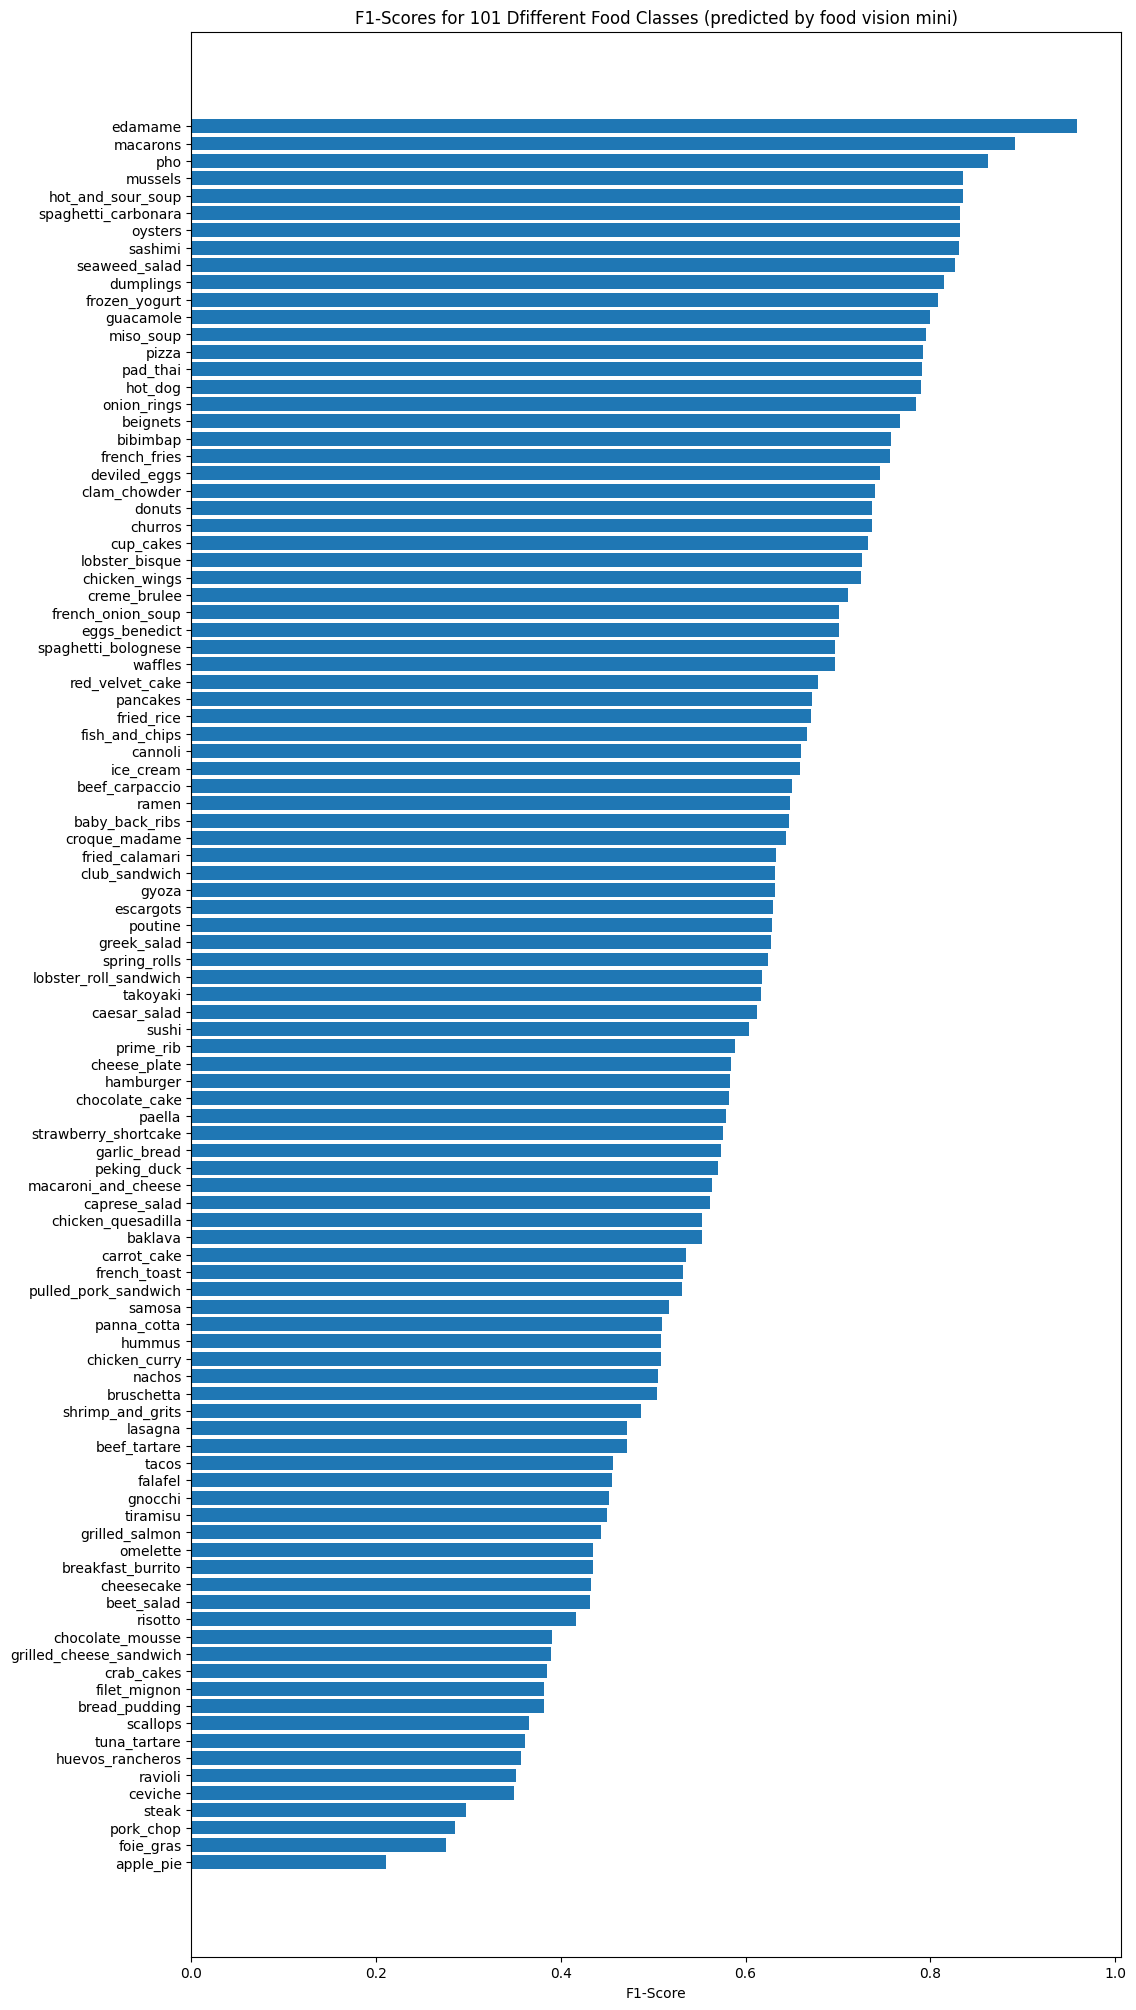

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores=ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Scores for 101 Dfifferent Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io,read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [47]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image filename, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Rescale the image (if necessary)
  if scale:
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'' write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original images(s) along with the model's predictions, prediction probability and truth label.

1/1 [==============================] - 0s 63ms/step


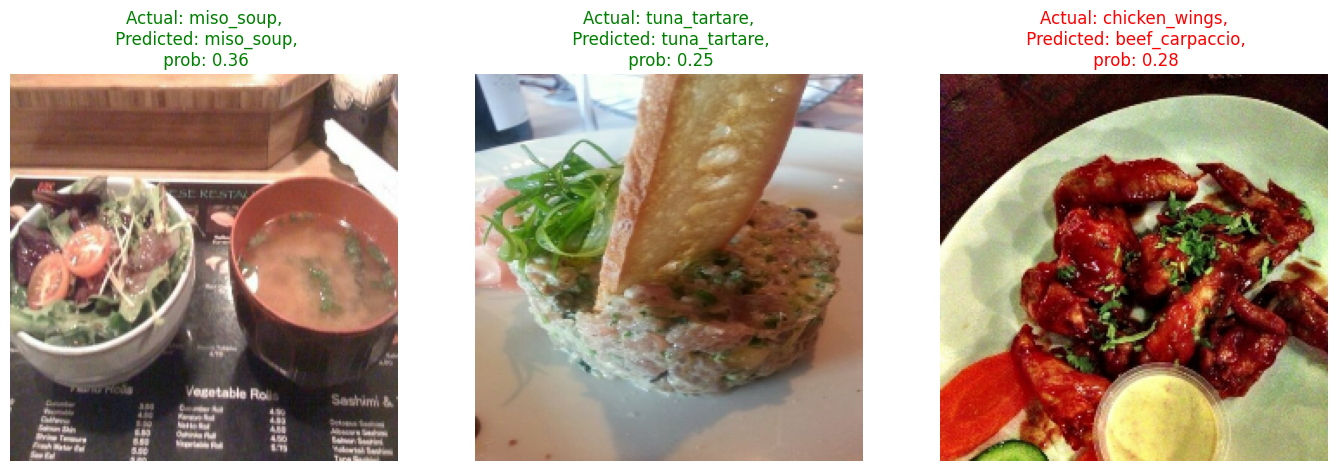

In [48]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] # get the highest prediction probability index
  class_dir = os.path.join(test_dir, class_name)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name},\n Predicted: {pred_class},\n prob: {pred_prob.max():.2f}", color=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [50]:
# Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

In [54]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      85   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0       0   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100      74   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100      93   

       pred_conf y_true_classname y_pred_classname  
0       0.617643        apple_pie           samosa  
1       0.673150        apple_pie        apple_pie  
2       0.491397        apple_pie        apple_pie  
3       0.251752        apple_pie        apple_pie  
4       0.632290        apple_pie    bread_pudding  
...          ...              ...              ...  
25245   0.908589          waffles          waffles  
25246   0.883416          waffles          waffles  
25247   0.327391          waffles      peking_duck  
25248   0.293224          waffles          waffles  
25249   0.237154          waffles            steak  

[25250 rows x 6 columns]

In [55]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      85   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       0   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.617643        apple_pie           samosa         False  
1   0.673150        apple_pie        apple_pie          True  
2   0.491397        apple_pie        apple_pie          True  
3   0.251752        apple_pie        apple_pie          True  
4   0.632290        apple_pie    bread_pudding         False

In [62]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)
#

img_path  y_true  y_pred  \
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
14482  b'/content/101_food_classes_10_percent/test/hu...      57      51   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
4836   b'/content/101_food_classes_10_percent/test/ch...      19       9   
722    b'/content/101_food_classes_10_percent/test/ba...       2      85   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   
9690   b'/content/101_food_classes_10_percent/test/fi...      38      20   
18611  b'/content/101_food_classes_10_percent/test/pe...      74      85   
20067  b'/content/101_food_classes_10_percent/test/pu...      80      53   
20191  b'/content/101_food_classes_10_percent/test/pu...      80       9   
17908  b'/content/101_food_classes_10_percent/test/pa...      71      65   
11697  b'/content/101_food_classes_10_percent/test/ga...      46      35   
9402   b'/content/101_food_classes_10_percent/test/fi...      37      79   
10947  b'/content/101_food_classes_10_percent/test/fr...      43      68   
25166  b'/content/101_food_classes_10_percent/test/wa...     100      42   
15613  b'/content/101_food_classes_10_percent/test/ma...      62      24   
12396  b'/content/101_food_classes_10_percent/test/gr...      49      53   
18935  b'/content/101_food_classes_10_percent/test/ph...      75      33   
9227   b'/content/101_food_classes_10_percent/test/fa...      36      26   
5114   b'/content/101_food_classes_10_percent/test/ch...      20      38   

       pred_conf         y_true_classname   y_pred_classname  pred_correct  
18001   0.997741                 pancakes           omelette         False  
14482   0.996409                   hummus          guacamole         False  
23797   0.996385                    sushi            sashimi         False  
4836    0.995723       chicken_quesadilla  breakfast_burrito         False  
722     0.993208                  baklava             samosa         False  
10880   0.993196           fried_calamari        onion_rings         False  
9690    0.990693           fish_and_chips      chicken_wings         False  
18611   0.989474              peking_duck             samosa         False  
20067   0.989370     pulled_pork_sandwich          hamburger         False  
20191   0.988252     pulled_pork_sandwich  breakfast_burrito         False  
17908   0.988240                   paella            mussels         False  
11697   0.985691             garlic_bread          escargots         False  
9402    0.984290             filet_mignon          prime_rib         False  
10947   0.983710           fried_calamari        onion_rings         False  
25166   0.983079                  waffles       french_toast         False  
15613   0.980301      macaroni_and_cheese       clam_chowder         False  
12396   0.980240  grilled_cheese_sandwich          hamburger         False  
18935   0.980049                      pho            edamame         False  
9227    0.979091                  falafel         crab_cakes         False  
5114    0.979064            chicken_wings     fish_and_chips         False

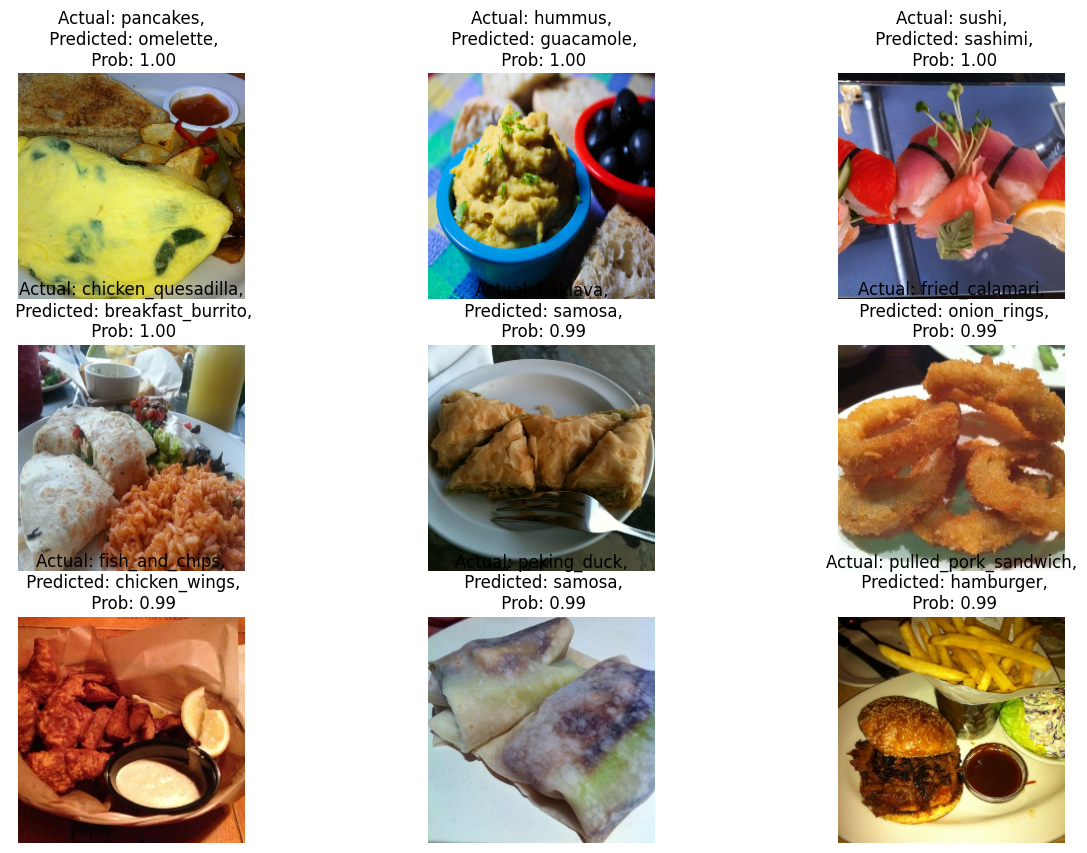

In [66]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability.
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  # Create subplots (5 rows, 4 columns)
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname},\n Predicted: {y_pred_classname},\n Prob: {pred_prob:.2f}")
  plt.axis(False);
  # Turn on x axis gridlines

## Test out the big dog model on our own custom images

In [67]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-10-23 17:25:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  78.7MB/s    in 0.2s    

2024-10-23 17:25:19 (78.7 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [68]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg']

1/1 [==============================] - 0s 61ms/step


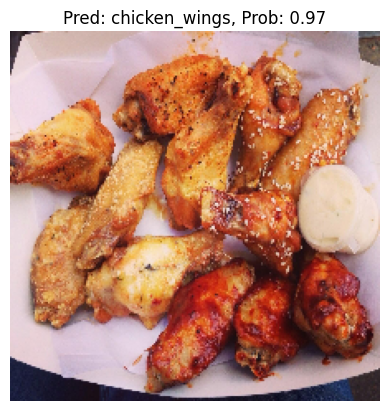

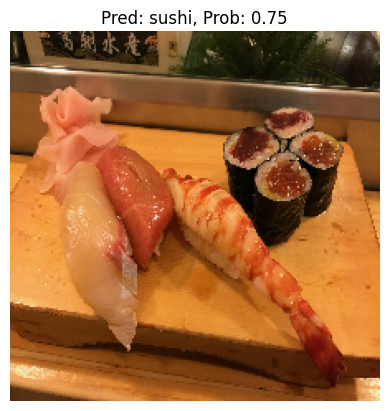

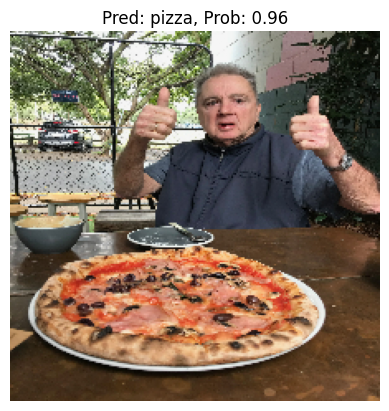

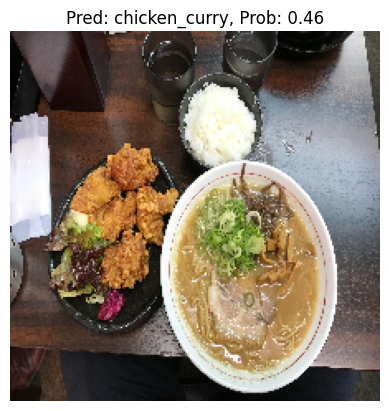

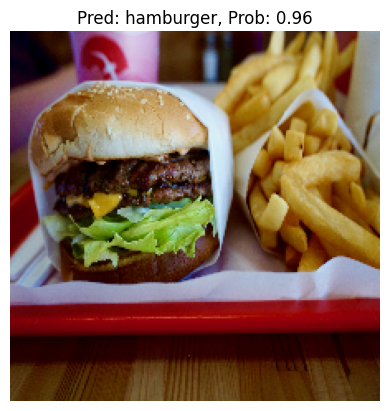

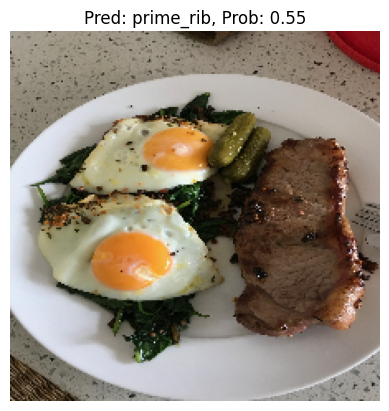

In [69]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with highest prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}")
  plt.axis(False)